In [1]:
%load_ext autoreload
%autoreload 2

import pickle as pkl
import gzip
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.insert(1, './awp/utils/')

from DataLoader import *
from training import *
from capacity import *

## scikit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [87]:
def flip_train(X_train, X_test, y_train, y_test, n, model):
    base_model = model.fit(X_train, y_train)
    print(base_model.score(X_train, y_train), base_model.score(X_test, y_test))
    base_acc = base_model.score(X_test, y_test)
    base_prob = base_model.predict_proba(X_train)
    
    flip_prob = np.zeros((n, 2))
    acc = np.zeros((n,))
    for i in tqdm(range(n)):
        y_train_flip = y_train.copy()
        y_train_flip[i] = 1-y_train[i]

        assert (y_train_flip!=y_train).sum() == 1

        model = model.fit(X_train, y_train_flip)

        flip_prob[i, :] = model.predict_proba(X_train[i, :].reshape(1, -1))
        acc[i] = model.score(X_test, y_test)
    
    likelihood = np.zeros((2, n, 2))
    likelihood[0, :, :] = base_prob[:n, :]
    likelihood[1, :, :] = flip_prob
    
    cap = compute_capacity(likelihood)
    return cap, base_acc, acc

In [103]:
def compute_cap_eps(cap, base_loss, loss, tols, quantiles):
    cap_mean = np.zeros((len(quantile), len(tols)))
    cap_std = np.zeros((len(quantile), len(tols)))
    
    for i in range(len(tols)):
        idx = loss <= base_loss + tols[i]
        cap_tol = cap[idx]
        for j in range(len(quantiles)):
            cap_q = np.percentile(cap_tol, quantile[j])
            cap_mean[j, i] = cap_tol[cap_tol > cap_q].mean()
            cap_std[j, i] = cap_tol[cap_tol > cap_q].std()/(cap_tol > cap_q).sum()
            
    return cap_mean, cap_std

In [69]:
ntest = 0.3
n = 1000
model = LogisticRegression(random_state=1)

In [88]:
df = load_data(name='compas')
X = df.drop(['is_recid'], axis=1).values
y = df['is_recid'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ntest, random_state=42)
compas_cap, compas_base_loss, compas_loss = flip_train(X_train, X_test, y_train, y_test, n, model)

0.6802923659989172 0.6660353535353535


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.40it/s]


In [89]:
df = load_hsls('./data/HSLS/', 'hsls_df_knn_impute_past_v2.pkl', [])
X = df.drop(['gradebin'], axis=1).values
y = df['gradebin'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ntest, random_state=42)
hsls_cap, hsls_base_loss, hsls_loss = flip_train(X_train, X_test, y_train, y_test, n, model)

0.7336549822764868 0.7323684815070066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.44it/s]


In [93]:
quantile = np.array([95, 99])
tols = np.array([0.01, 0.02, 0.05, 0.10])

In [104]:
compas_cap_mean, compas_cap_std = compute_cap_eps(compas_cap, compas_base_loss, compas_loss, tols, quantile)
hsls_cap_mean, hsls_cap_std = compute_cap_eps(hsls_cap, hsls_base_loss, hsls_loss, tols, quantile)

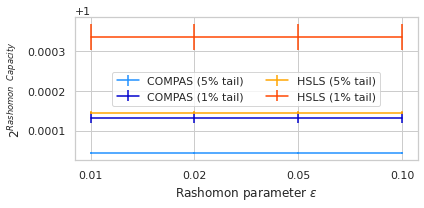

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
compas_color = ['dodgerblue', 'mediumblue']
hsls_color = ['orange', 'orangered']
x = np.arange(len(tols))

for i in range(len(quantile)):
    ax.errorbar(x, y=2**compas_cap_mean[i, :], yerr=compas_cap_std[i, :], 
                label='COMPAS ({:1d}% tail)'.format(100-quantile[i]), color=compas_color[i])
# ax.errorbar(x, y=2**compas_cap_mean[1, :], yerr=compas_cap_std[1, :])
for i in range(len(quantile)):
    ax.errorbar(x, y=2**hsls_cap_mean[i, :], yerr=hsls_cap_std[i, :], 
                label='HSLS ({:1d}% tail)'.format(100-quantile[i]), color=hsls_color[i])
    
ax.set_xticks(np.arange(len(tols)))
ax.set_xticklabels(['{:.2f}'.format(e) for e in tols])
ax.set_xlabel(r'Rashomon parameter $\epsilon$')
ax.set_ylabel(r'$2^{Rashomon\ \ Capacity}$');
ax.legend(loc='center', ncol=2)

plt.tight_layout()
plt.savefig('compas-hsls-flip.png', format='png', dpi=300)